In [53]:
from pyspark.sql import functions as F, SparkSession
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import DecisionTreeRegressor, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.sql.types import BooleanType
from pyspark.ml.feature import StringIndexer, OneHotEncoder
import pandas as pd



In [54]:
# Create a Spark Session
spark = (
    SparkSession.builder.appName("consumer transaction model")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "4g")
    .config("spark.execturo.memory", "2g")
    .getOrCreate()
)

# Load data

In [55]:
consumer_info = spark.read.parquet('../data/curated/consumer_info.parquet')
transaction_records = spark.read.parquet('../data/curated/transactions.parquet')
fraudulent_consumer_rate = spark.read.parquet('../data/curated/consumer_fraud_prob.parquet')
personal_fraud = spark.read.csv('../data/curated/personal_fraud.csv', header=True, inferSchema=True)
postcode_info = spark.read.csv('../data/curated/postcode_info.csv', header=True, inferSchema=True)

personal_fraud = personal_fraud.drop(personal_fraud.columns[0])
postcode_info = postcode_info.drop(postcode_info.columns[0])

# Prepare data frame for modelling

In [56]:
# Add consumer info to transaction records
consumer_transaction_records = transaction_records.join(consumer_info, on="consumer_id", how="inner")

In [57]:
# Merge transaction with consumer infomation
transaction_fraudulent_consumer = transaction_records.join(fraudulent_consumer_rate, on=["order_datetime", "consumer_id"], how="inner")
transaction_fraudulent_consumer_with_info = consumer_info.join(transaction_fraudulent_consumer, on="consumer_id", how="inner")

In [58]:
# number of unique available fraudulent consumer (does not lost any consumer after merging with transaction records)
transaction_fraudulent_consumer_with_info.select("consumer_id").distinct().count()

20128

In [59]:
# Average fraud probability in each postcode or state
fraudulent_consumer_group_by_postcode = transaction_fraudulent_consumer_with_info.groupBy(["postcode"]).agg(F.avg("fraud_probability").alias("average_fraud_prob_of_postcode"))

fraudulent_consumer_group_by_state = transaction_fraudulent_consumer_with_info.groupBy(["state"]).agg(F.avg("fraud_probability").alias("average_fraud_prob_of_state"))

In [60]:
# analysis order value, consider the variance of order value and purchase frequency
consumer_transaction_value_analysis =  consumer_transaction_records.groupBy("consumer_id", "state", "postcode") \
                                        .agg(
                                            F.avg("dollar_value").alias("average_dollar_value"),
                                            F.min("dollar_value").alias("min_dollar_value"),
                                            F.max("dollar_value").alias("max_dollar_value"),
                                            F.count("dollar_value").alias("transaction_count"),
                                            F.stddev("dollar_value").alias("stddev_dollar_value")
                                        )

In [73]:
transaction_fraudulent_consumer_summary = transaction_fraudulent_consumer_with_info \
    .join(consumer_transaction_value_analysis, on=["consumer_id", "state"], how="left") \
    .join(fraudulent_consumer_group_by_postcode, on="postcode", how="inner") \
    .join(fraudulent_consumer_group_by_state, on="state", how="inner")

### missing 2755 in postcode_info

In [74]:
# Get infomation about personal fraud and income from external dataset
postcode_info = postcode_info.drop("state", "long", "lat", "lgacode")
transaction_fraudulent_consumer_summary = transaction_fraudulent_consumer_summary.join(personal_fraud, on="state", how="inner")
transaction_fraudulent_consumer_summary = transaction_fraudulent_consumer_summary.join(postcode_info, on="postcode", how="inner")

In [75]:
# Get proportion of the money used to purchase item with respect to income
# average income
transaction_fraudulent_consumer_summary = transaction_fraudulent_consumer_summary.withColumn("Proportion_between_max_order_value_mean_income", F.col("max_dollar_value") / (F.col("mean_income") * 1.5) )
transaction_fraudulent_consumer_summary = transaction_fraudulent_consumer_summary.withColumn("Proportion_between_max_order_value_median_income", F.col("max_dollar_value") / (F.col("median_income") * 1.5))

# Total income
transaction_fraudulent_consumer_summary = transaction_fraudulent_consumer_summary.withColumn("Proportion_between_total_order_value_mean_income", F.col("average_dollar_value") * F.col("transaction_count") / (F.col("mean_income") * 1.5))
transaction_fraudulent_consumer_summary = transaction_fraudulent_consumer_summary.withColumn("Proportion_between_total_order_value_median_income", F.col("average_dollar_value") * F.col("transaction_count") / (F.col("median_income") * 1.5))


In [12]:
transaction_fraudulent_consumer_summary.count()

80537

### Analysis datetime information

In [76]:
# Convert 'order_datetime' from string to date format
transaction_fraudulent_consumer_summary = transaction_fraudulent_consumer_summary.withColumn("order_datetime", F.to_date("order_datetime", "yyyy-MM-dd"))
cutoff_date = "2021-03-07"
transaction_fraudulent_consumer_summary = transaction_fraudulent_consumer_summary.filter(F.col("order_datetime") >= F.lit(cutoff_date))

# Add a new column 'transaction_count_last_n_days' that counts the transactions within n days before each transaction
window_spec = Window.partitionBy("consumer_id").orderBy(F.col("order_datetime").cast("long")) \
    .rangeBetween(-7 * 86400, 0)  # 7 days in seconds (86400 seconds = 1 day)

transaction_fraudulent_consumer_summary = transaction_fraudulent_consumer_summary.withColumn("transaction_count_last_7_days", F.count("order_datetime").over(window_spec))



In [77]:
# Return the corresponding day of the week for the given date in the DataFrame.

transaction_fraudulent_consumer_summary = transaction_fraudulent_consumer_summary.withColumn("day_of_week", F.date_format("order_datetime", "EEEE"))
transaction_fraudulent_consumer_summary = transaction_fraudulent_consumer_summary.withColumn("is_weekend", F.date_format("order_datetime", "EEEE").isin("Saturday", "Sunday"))


In [17]:
transaction_fraudulent_consumer_summary.show(5)

+--------+-----+-----------+--------------------+------+--------------+------------+------------------+--------------------+------------------+-----+--------+--------------------+--------------------+-----------------+-----------------+-------------------+------------------------------+---------------------------+------------------+-----------+----------+-------------+-----------+----------------------------------------------+------------------------------------------------+------------------------------------------------+--------------------------------------------------+-----------------------------+-----------+----------+
|postcode|state|consumer_id|                name|gender|order_datetime|merchant_abn|      dollar_value|            order_id| fraud_probability|state|postcode|average_dollar_value|    min_dollar_value| max_dollar_value|transaction_count|stddev_dollar_value|average_fraud_prob_of_postcode|average_fraud_prob_of_state|victimisation_rate|rse_percent|median_age|median_inc

In [78]:
transaction_fraudulent_consumer_summary.count()

80288

# Visualisation

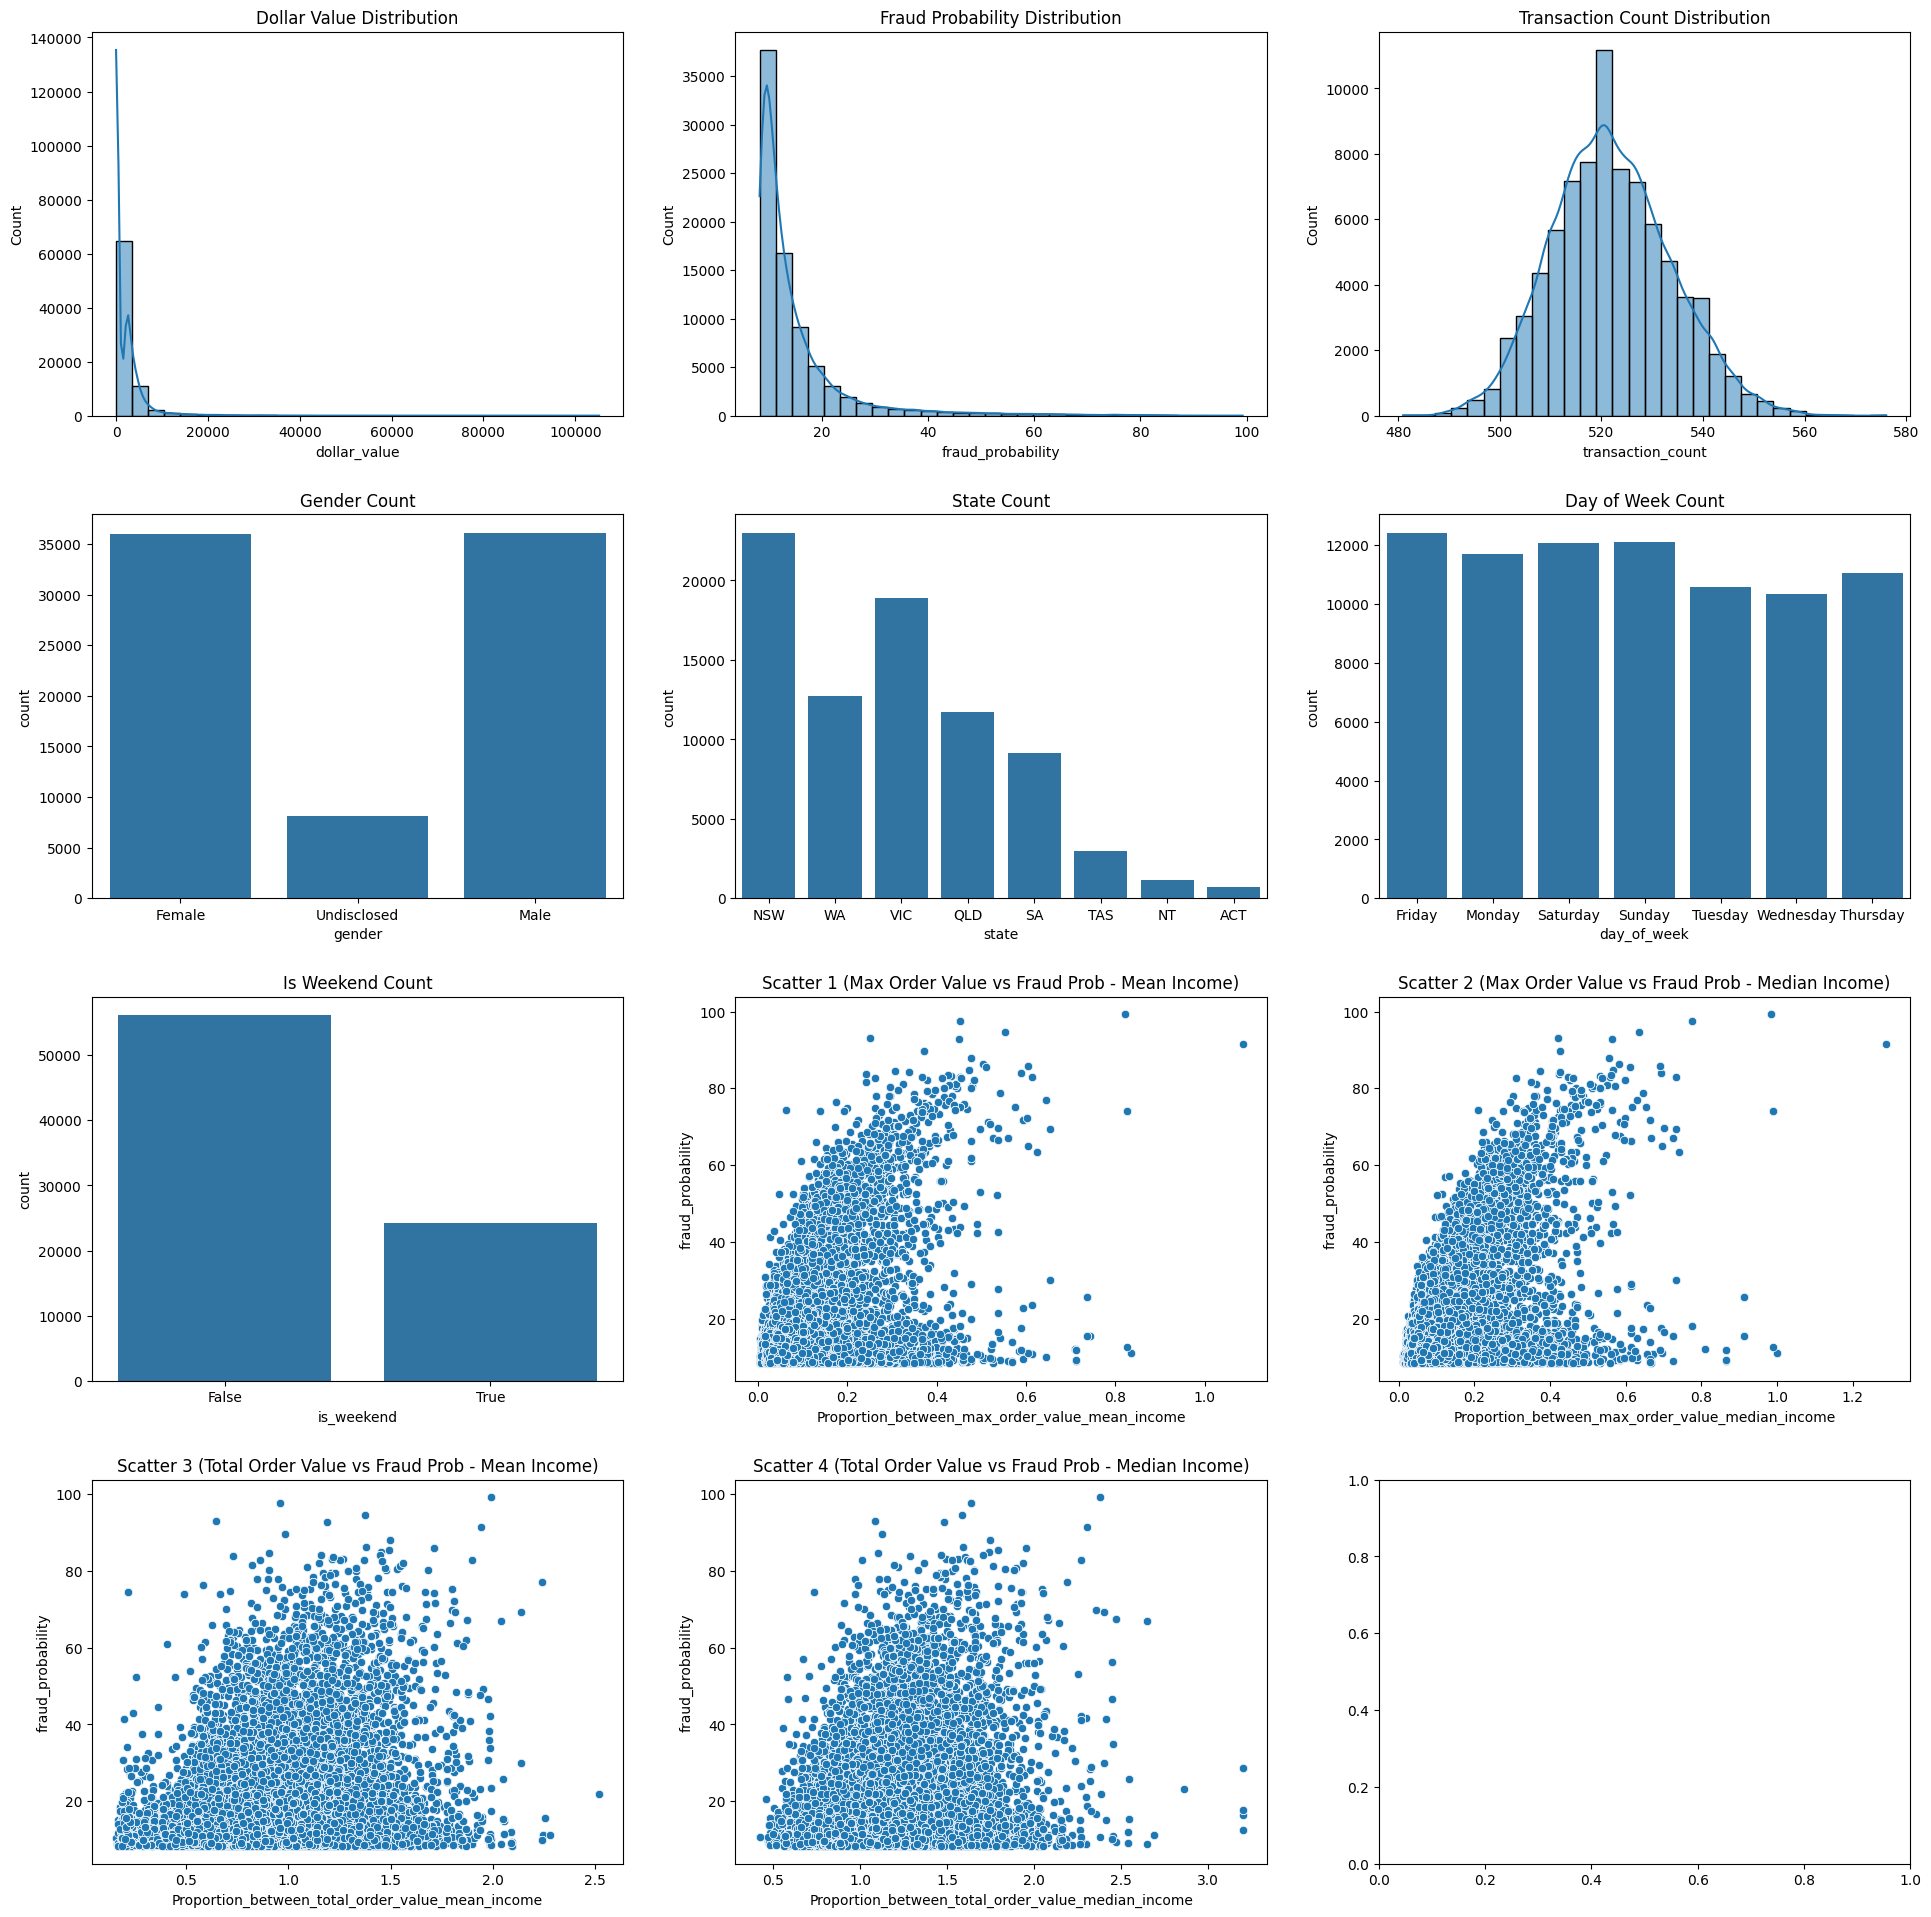

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert relevant columns to Pandas
df_pandas = transaction_fraudulent_consumer_summary.select(
    "dollar_value", "fraud_probability", "average_dollar_value", 
    "min_dollar_value", "max_dollar_value", "transaction_count", 
    "median_income", "mean_income", "state", "gender", 
    "day_of_week", "is_weekend", "Proportion_between_max_order_value_mean_income",
    "Proportion_between_max_order_value_median_income", 
    "Proportion_between_total_order_value_mean_income", 
    "Proportion_between_total_order_value_median_income"
).toPandas()

# Set up a big plot grid
fig, axes = plt.subplots(4, 3, figsize=(20, 20))  # 4x3 grid of subplots
fig.tight_layout(pad=5.0)  # Adjust spacing between plots

# Define plots in a dictionary for looping
plots = {
    "Dollar Value Distribution": ("dollar_value", "hist"),
    "Fraud Probability Distribution": ("fraud_probability", "hist"),
    "Transaction Count Distribution": ("transaction_count", "hist"),
    "Gender Count": ("gender", "count"),
    "State Count": ("state", "count"),
    "Day of Week Count": ("day_of_week", "count"),
    "Is Weekend Count": ("is_weekend", "count"),
    "Scatter 1 (Max Order Value vs Fraud Prob - Mean Income)": ("Proportion_between_max_order_value_mean_income", "scatter1"),
    "Scatter 2 (Max Order Value vs Fraud Prob - Median Income)": ("Proportion_between_max_order_value_median_income", "scatter2"),
    "Scatter 3 (Total Order Value vs Fraud Prob - Mean Income)": ("Proportion_between_total_order_value_mean_income", "scatter3"),
    "Scatter 4 (Total Order Value vs Fraud Prob - Median Income)": ("Proportion_between_total_order_value_median_income", "scatter4")
}

# Loop through plots dictionary and generate plots
for i, (plot_title, (feature, plot_type)) in enumerate(plots.items()):
    ax = axes[i // 3, i % 3]  # Select subplot position

    if plot_type == "hist":
        sns.histplot(df_pandas[feature], bins=30, kde=True, ax=ax)
    elif plot_type == "count":
        sns.countplot(x=feature, data=df_pandas, ax=ax)
    elif plot_type.startswith("scatter"):
        if plot_type == "scatter1":
            sns.scatterplot(x="Proportion_between_max_order_value_mean_income", y="fraud_probability", data=df_pandas, ax=ax)
        elif plot_type == "scatter2":
            sns.scatterplot(x="Proportion_between_max_order_value_median_income", y="fraud_probability", data=df_pandas, ax=ax)
        elif plot_type == "scatter3":
            sns.scatterplot(x="Proportion_between_total_order_value_mean_income", y="fraud_probability", data=df_pandas, ax=ax)
        elif plot_type == "scatter4":
            sns.scatterplot(x="Proportion_between_total_order_value_median_income", y="fraud_probability", data=df_pandas, ax=ax)

    ax.set_title(plot_title)

# Show the entire plot
plt.show()


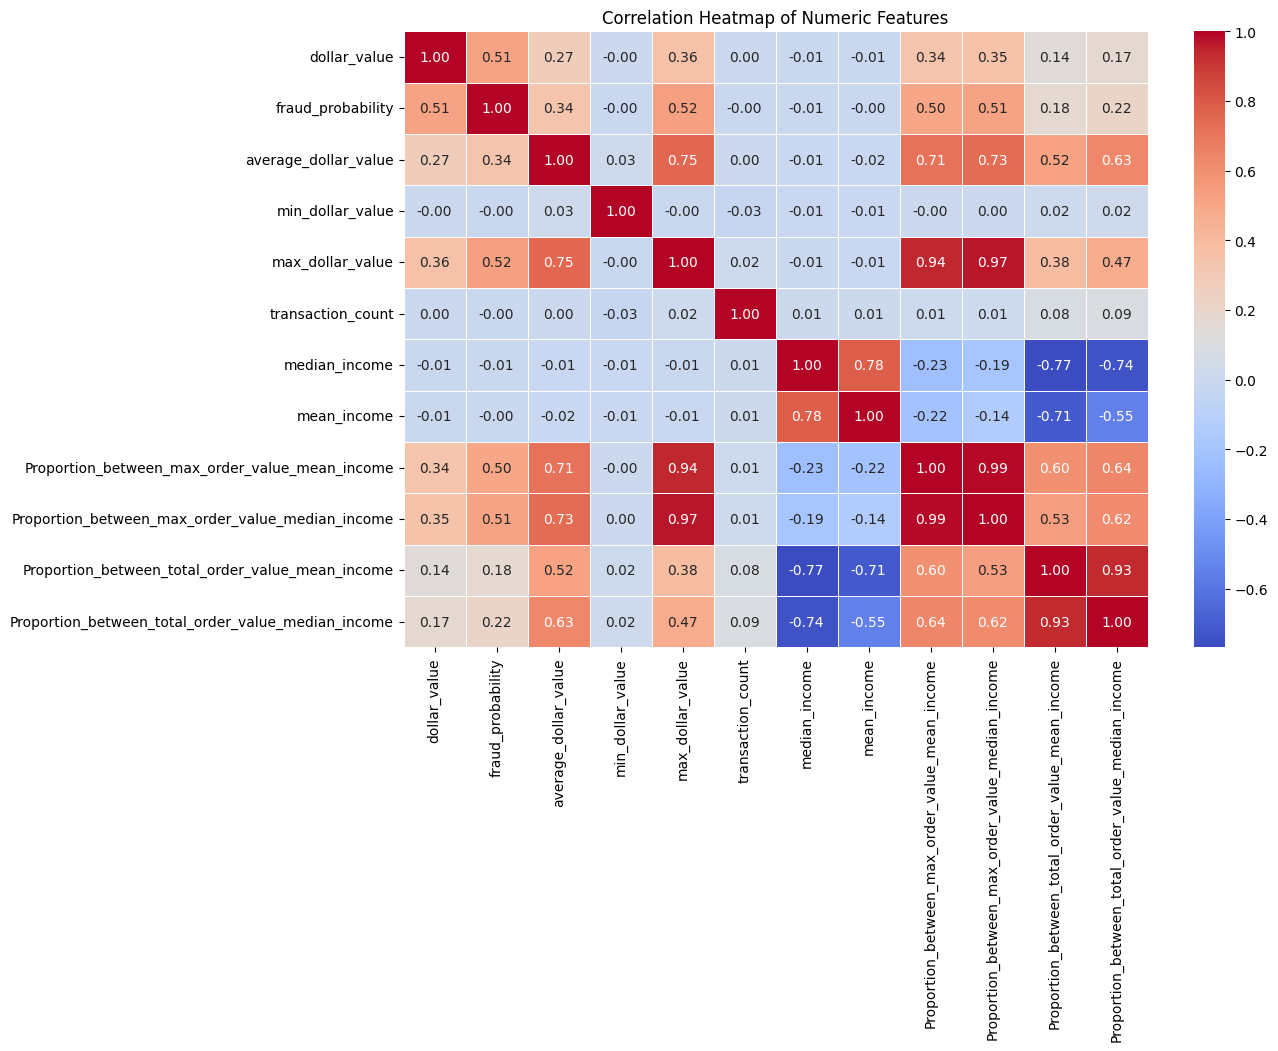

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the PySpark DataFrame to Pandas for plotting
df_pandas = transaction_fraudulent_consumer_summary.select(
    "dollar_value", "fraud_probability", "average_dollar_value", 
    "min_dollar_value", "max_dollar_value", "transaction_count", 
    "median_income", "mean_income", "Proportion_between_max_order_value_mean_income",
    "Proportion_between_max_order_value_median_income", 
    "Proportion_between_total_order_value_mean_income", 
    "Proportion_between_total_order_value_median_income"
).toPandas()

# Calculate the correlation matrix for numeric columns
corr_matrix = df_pandas.corr()

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Add title
plt.title("Correlation Heatmap of Numeric Features")

# Show the plot
plt.show()


# Idea
1. Time Frequency feature: https://ieeexplore.ieee.org/document/9399421/

# Modelling

In [19]:
# List of features to be used in the model
features = [
    "average_dollar_value", "min_dollar_value", "max_dollar_value", 
    "transaction_count", "stddev_dollar_value", 
    "average_fraud_prob_of_postcode", "average_fraud_prob_of_state",
    "victimisation_rate", "rse_percent", "Proportion_between_max_order_value_mean_income",
    "Proportion_between_max_order_value_median_income","Proportion_between_total_order_value_mean_income",
    "Proportion_between_total_order_value_median_income",
    "day_of_week_index", "is_weekend_index",
    "transaction_count_last_7_days"
]

features_dt = [
    "average_dollar_value", "min_dollar_value", "max_dollar_value",
    "average_fraud_prob_of_postcode",
    "Proportion_between_max_order_value_mean_income",
    "Proportion_between_max_order_value_median_income",
    #"day_of_week_index", 
    #"is_weekend_index",
    #"transaction_count_last_7_days"
]

features_rf = [
    "max_dollar_value", "average_fraud_prob_of_postcode", "average_dollar_value", 
    "rse_percent", 
    #"day_of_week_index", 
    #"is_weekend_index",
    #"transaction_count_last_7_days"
]

features_lr = [
    "average_dollar_value", "min_dollar_value",
    "average_fraud_prob_of_postcode", "average_fraud_prob_of_state",
    "Proportion_between_max_order_value_mean_income",
    "Proportion_between_max_order_value_median_income","Proportion_between_total_order_value_mean_income",
    "Proportion_between_total_order_value_median_income",
    #"day_of_week_index", 
    #"is_weekend_index",
    #"transaction_count_last_7_days"
]

In [20]:
transaction_fraudulent_consumer_summary = transaction_fraudulent_consumer_summary.withColumn("is_weekend", transaction_fraudulent_consumer_summary["is_weekend"].cast("integer"))

In [21]:
day_of_week_index = StringIndexer(inputCol="day_of_week", outputCol="day_of_week_index")
is_weekend_index = StringIndexer(inputCol="is_weekend", outputCol="is_weekend_index")


# day_of_week_index, 
# is_weekend_index, 
assembler_dt = VectorAssembler(inputCols=features_dt, outputCol="features")
pipeline_dt = Pipeline(stages = [assembler_dt])

assembler_rf = VectorAssembler(inputCols=features_rf, outputCol="features")
pipeline_rf = Pipeline(stages = [assembler_rf])

assembler_lr = VectorAssembler(inputCols=features_lr, outputCol="features")
pipeline_lr = Pipeline(stages = [assembler_lr])

data_dt = pipeline_dt.fit(transaction_fraudulent_consumer_summary).transform(transaction_fraudulent_consumer_summary)
data_rf = pipeline_rf.fit(transaction_fraudulent_consumer_summary).transform(transaction_fraudulent_consumer_summary)
data_lr = pipeline_lr.fit(transaction_fraudulent_consumer_summary).transform(transaction_fraudulent_consumer_summary)

train_data_dt, test_data_dt = data_dt.randomSplit([0.8, 0.2])
train_data_rf, test_data_rf = data_rf.randomSplit([0.8, 0.2])
train_data_lr, test_data_lr = data_lr.randomSplit([0.8, 0.2])


In [22]:
data_rf.printSchema()

root
 |-- postcode: integer (nullable = true)
 |-- state: string (nullable = true)
 |-- consumer_id: long (nullable = true)
 |-- name: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- merchant_abn: long (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- order_id: string (nullable = true)
 |-- fraud_probability: double (nullable = true)
 |-- state: string (nullable = true)
 |-- postcode: integer (nullable = true)
 |-- average_dollar_value: double (nullable = true)
 |-- min_dollar_value: double (nullable = true)
 |-- max_dollar_value: double (nullable = true)
 |-- transaction_count: long (nullable = true)
 |-- stddev_dollar_value: double (nullable = true)
 |-- average_fraud_prob_of_postcode: double (nullable = true)
 |-- average_fraud_prob_of_state: double (nullable = true)
 |-- victimisation_rate: double (nullable = true)
 |-- rse_percent: double (nullable = true)
 |-- median_age: double (nullable = true)
 |-

In [23]:
# Define model regressor
dt = DecisionTreeRegressor(labelCol="fraud_probability", featuresCol="features")

rf = RandomForestRegressor(labelCol="fraud_probability", featuresCol="features")

lr = LinearRegression(labelCol="fraud_probability", featuresCol="features")


In [24]:
# Parameter grid
dt_param_grid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [3, 5, 7]) \
    .addGrid(dt.maxBins, [32, 64]) \
    .build()


rf_param_grid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20]) \
    .addGrid(rf.maxDepth, [5, 7]) \
    .build()

lr_param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()


In [25]:
# Evaluator for regression models
rmse_evaluator = RegressionEvaluator(
    labelCol="fraud_probability", 
    predictionCol="prediction", 
    metricName="rmse"  
)

r2_evaluator = RegressionEvaluator(
    labelCol="fraud_probability",
    predictionCol="prediction",
    metricName="r2" 
)

# Cross-validation 
dt_cv = CrossValidator(
    estimator=dt,
    estimatorParamMaps=dt_param_grid,
    evaluator=r2_evaluator,
    numFolds=3
)

rf_cv = CrossValidator(
    estimator=rf,
    estimatorParamMaps=rf_param_grid,
    evaluator=r2_evaluator,
    numFolds=3
)

lr_cv = CrossValidator(
    estimator=lr,
    estimatorParamMaps=lr_param_grid,
    evaluator=r2_evaluator,
    numFolds=3
)


In [26]:
# Pipeline 
dt_pipeline = Pipeline(stages=[dt_cv])

rf_pipeline = Pipeline(stages=[rf_cv])

lr_pipeline = Pipeline(stages=[lr_cv])


In [27]:
# Fit model

# 6 mins
dt_model = dt_pipeline.fit(train_data_dt)




In [28]:
# 7 mins
rf_model = rf_pipeline.fit(train_data_rf)


In [29]:

# 4 mins
lr_model = lr_pipeline.fit(train_data_lr)

24/09/27 19:18:11 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/09/27 19:18:11 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
24/09/27 19:18:12 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


# Evaluation

In [30]:
# Make predictions on the test data
dt_predictions = dt_model.transform(test_data_dt)
rf_predictions = rf_model.transform(test_data_rf)
lr_predictions = lr_model.transform(test_data_lr)


dt_rmse = rmse_evaluator.evaluate(dt_predictions)
dt_r2 = r2_evaluator.evaluate(dt_predictions)
print(f"Decision Tree RMSE: {dt_rmse}")
print(f"Decision Tree R2: {dt_r2}")           # RMSE: 6.321439678625029 R2: 0.5426608139433955

rf_rmse = rmse_evaluator.evaluate(rf_predictions)
rf_r2 = r2_evaluator.evaluate(rf_predictions)
print(f"Random Forest RMSE: {rf_rmse}")
print(f"Random Forest R2: {rf_r2}")            # RMSE: 6.2324836442813565 R2: 0.5554417100291846

lr_rmse = rmse_evaluator.evaluate(lr_predictions)
lr_r2 = r2_evaluator.evaluate(lr_predictions)
print(f"Linear Regression RMSE: {lr_rmse}")
print(f"Linear Regression R2: {lr_r2}")  # RMSE: 7.031157543875003 R2: 0.434203734698708


Decision Tree RMSE: 7.352595369646301
Decision Tree R2: 0.4148175102806174


Random Forest RMSE: 7.2044883990615975
Random Forest R2: 0.4257468124378345


Linear Regression RMSE: 7.925194297907184
Linear Regression R2: 0.33484702776399455


`Best model hyperparameters`

In [31]:
best_dt_model = dt_model.stages[-1].bestModel
print(f"Best Decision Tree maxDepth: {best_dt_model._java_obj.getMaxDepth()}")
print(f"Best Decision Tree maxBins: {best_dt_model._java_obj.getMaxBins()}")


best_rf_model = rf_model.stages[-1].bestModel
print(f"Best Random Forest numTrees: {best_rf_model.getNumTrees}")
print(f"Best Random Forest maxDepth: {best_rf_model.getMaxDepth()}")


Best Decision Tree maxDepth: 7
Best Decision Tree maxBins: 64
Best Random Forest numTrees: 20
Best Random Forest maxDepth: 7


### __Feature importances__

In [32]:
feature_names_dt = assembler_dt.getInputCols()
feature_names_rf = assembler_rf.getInputCols()
feature_names_lr = assembler_lr.getInputCols()

`Random forest and decision tree`

In [33]:
best_rf_model = rf_model.stages[0].bestModel
best_dt_model = dt_model.stages[0].bestModel

dt_feature_importances = best_dt_model.featureImportances
rf_feature_importances = best_rf_model.featureImportances

rf_importances_df = pd.DataFrame({
    "Feature": feature_names_rf,
    "Importance": rf_feature_importances.toArray()
}).sort_values(by="Importance", ascending=False)

dt_importances_df = pd.DataFrame({
    "Feature": feature_names_dt,
    "Importance": dt_feature_importances.toArray()
}).sort_values(by="Importance", ascending=False)

print(rf_importances_df)
print()
print(dt_importances_df)

                          Feature  Importance
0                max_dollar_value    0.497971
1  average_fraud_prob_of_postcode    0.342785
2            average_dollar_value    0.145573
3                     rse_percent    0.013671

                                            Feature  Importance
2                                  max_dollar_value    0.631869
3                    average_fraud_prob_of_postcode    0.312145
0                              average_dollar_value    0.032966
1                                  min_dollar_value    0.013518
4    Proportion_between_max_order_value_mean_income    0.005012
5  Proportion_between_max_order_value_median_income    0.004490


`Linear regression`

In [34]:

# Get coefficients 
best_lr_model = lr_model.stages[0].bestModel
coefficients = best_lr_model.coefficients
# Get feature names from the VectorAssembler
feature_importances = pd.DataFrame({
    "Feature": feature_names_lr,
    "Coefficient": coefficients
}).sort_values(by="Coefficient", ascending=False)

print(feature_importances)


                                             Feature  Coefficient
5   Proportion_between_max_order_value_median_income    92.387534
6   Proportion_between_total_order_value_mean_income     3.314018
2                     average_fraud_prob_of_postcode     0.653227
3                        average_fraud_prob_of_state     0.024445
0                               average_dollar_value     0.000719
1                                   min_dollar_value    -0.065352
7  Proportion_between_total_order_value_median_in...    -8.472302
4     Proportion_between_max_order_value_mean_income   -36.187100
